# Challenge: Clasificación de la Severidad de la Colitis Ulcerosa Colonoscópica

### Realizado por: 
1. John Anderson Acosta 202212004
2. Valeria Leticia Vidales 202216072
3. Juana Dayana Salazar 202211524
4. Maria Lucia Palacios 202014650

### Contexto

La colitis ulcerativa es un tipo de enfermedad inflamatoria intestinal que causa inflamación y llagas o úlceras en una parte del sistema digestivo. En específico, afecta el recubrimiento más profundo del intestino grueso, también denominado colon, y el recto. 

La endoscopia es el método de diagnóstico más eficaz para la colitis ulcerosa. Durante este procedimiento, se examina la superficie interna del intestino con una cámara flexible, buscando hallazgos como: eritemas, friabilidad de la mucosa, ulceración superficial y pérdida del patrón vascular del colon.

La valoración de la actividad endoscópica en la colitis ulcerosa (CU) resulta esencial para guiar el tratamiento y monitorizar la evolución de la enfermedad. Sin embargo, la inconsistencia en la interpretación y el diagnóstico entre distintos observadores compromete la precisión de esta evaluación. Con el fin de superar este desafío, se busca implementar un sistema de diagnóstico asistido por computadora que utilice aprendizaje profundo para disminuir la subjetividad y aumentar la confiabilidad de la valoración.

### Dataset

Con este fin, se recolectó un compendio de imágenes endoscópicas de pacientes con colitis ulcerosa para crear un conjunto de datos que permita el desarrollo de modelos de aprendizaje profundo.

El dataset esta compuesto por 9590 imágenes que pueden ser utilizadas para entrenamiento y validación, y 1686 imágenes que constituyen el conjunto de prueba, destinadas para evaluar el desempeño del modelo final.

Con el fin de cuantificar la severidad de esta condición se utiliza el Mayo Endoscopic Score (MES), el cual refleja la afectación de la mucosa directamente mediante el examen endoscópico y proporciona una evaluación precisa sobre la condición de un paciente. Este se compone de 4 categorías:

* Mayo 0: Colón normal o colitis ulcerosa inactiva.
* Mayo 1: Colitis ulcerosa leve, caracterizada por eritemas pequeños, disminución de los patrones vasculares y leve friabilidad de la mucosa.
* Mayo 2: Colitis ulcerosa moderada, con eritemas marcados, ausencia de patrones vasculares, friabilidad de la mucosa y erosiones en las paredes intestinales.
* Mayo 3: Colitis ulcerosa grave, con sangrado espontáneo y ulceración.

El conjunto de datos de entrenamiento se organiza en cuatro carpetas, cada una etiquetada con una de estas categorías del MES, y alberga las imágenes endoscópicas correspondientes a dicha clasificación.

El conjunto de prueba tan solo contiene las imágenes endoscópicas sin anotaciones. 

A continuación se muestra una pequeña muestra aleatoria de las imágenes del conjunto de entrenamiento, sin emabrgo, se recomienda realizar una exploración más profunda de estos para obtener un entendimiento de los datos más claro. 

In [1]:
# Las librerias necesarias para ejecutar el baseline se encuentran en el archivo requirements.txt adjunto

import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

from utils.color import Color
from utils.shape import Shape
from utils.dataset import Dataset
from utils.texture import Texture
from utils.features import Features

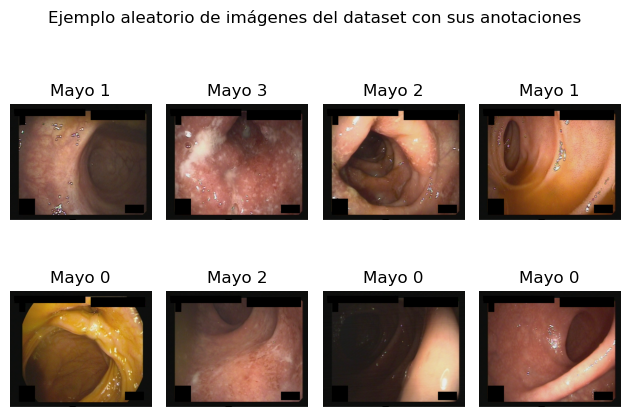

In [2]:
image_paths = glob(os.path.join("ChallengeDataset", "train", "*", "*.bmp"))

images_to_display = np.random.choice(image_paths, 8, replace=False)

rows = 2
cols = 4
fig, ax = plt.subplots(rows,cols, layout='tight')

k = 0
for i in range(rows):
    for j in range(cols):
        image = cv2.imread(images_to_display[k], cv2.IMREAD_COLOR_RGB)
        label = images_to_display[k].split(os.path.sep)[-2]
        ax[i, j].imshow(image)
        ax[i, j].set(title=label)
        ax[i, j].axis('off')
        k+=1

plt.suptitle("Ejemplo aleatorio de imágenes del dataset con sus anotaciones")
plt.show()

### Baseline

Como un primer acercamiento a este problema se propone una línea de base fundamentada en los conceptos de Machine Learning. Tras una experimentación exahustiva con diversos clasificadores y descriptores de imágenes se obtuvo que el clasificador con el mayor desempeño fue una máquina de soporte vectorial con un descriptor de imágenes multimodal que combina información de color, forma, y textura.    

Específicamente, el f1-score macro de este modelo en el conjunto de validación fue de $0.52$, mientras que en el conjunto de prueba alcanzó un valor de $0.49$.

A continuación se presenta la implemntación de este modelo: 

In [3]:
dataset = Dataset()

color = Color(
    image_size=(256, 256),
    color_space="rgb",
    pyramid=True,
    pacth_sizes=[(256, 256), (128, 128), (64, 64)],
    hist_type="joint",
    bins=6,
)
shape = Shape(
    image_size=(224, 224),
    orientations=9,
    pixels_per_cell=(32, 32),
    cells_per_block=(3, 3),
)
texture = Texture(
    filterbank=os.path.join("utils", "filterbank.mat"),
    textons=30,
    random_state=0,
    img_size=(256, 256),
    pyramid=True,
    pacth_sizes=[(256, 256), (128, 128), (64, 64)],
)

print("Creating dictionary of textons")
Im_list = np.array([cv2.imread(path) for path, _ in tqdm(dataset.train[:24], desc="Loading images")])
texture.create_dictionary_of_textons(Im_list)

features = Features(color, shape, texture)
train, valid, test = features(dataset)

Creating dictionary of textons


Filtering images: 100%|████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.74it/s]


Extracting features from train split


Extracting shape features: 100%|██████████████████████████████████████████████████| 7672/7672 [01:10<00:00, 108.79it/s]


Extracting features from valid split


Extracting shape features: 100%|██████████████████████████████████████████████████| 1918/1918 [00:12<00:00, 150.18it/s]


Extracting features from test split


Extracting shape features: 100%|██████████████████████████████████████████████████| 1686/1686 [00:10<00:00, 164.83it/s]


In [4]:
svm = cv2.ml.SVM_create()
svm.setKernel(cv2.ml.SVM_RBF)
svm.setType(cv2.ml.SVM_C_SVC)
svm.setC(4)
svm.setGamma(0.25)

svm.train(np.array(train['color_shape_texture'], dtype=np.float32), cv2.ml.ROW_SAMPLE, np.array(train["labels"], dtype=np.int32))                                   

True

### Evaluación baseline
#### Conjunto validación

              precision    recall  f1-score   support

           0       0.74      0.71      0.72      1050
           1       0.42      0.57      0.48       503
           2       0.48      0.28      0.35       223
           3       0.68      0.45      0.54       142

    accuracy                           0.60      1918
   macro avg       0.58      0.50      0.53      1918
weighted avg       0.62      0.60      0.60      1918



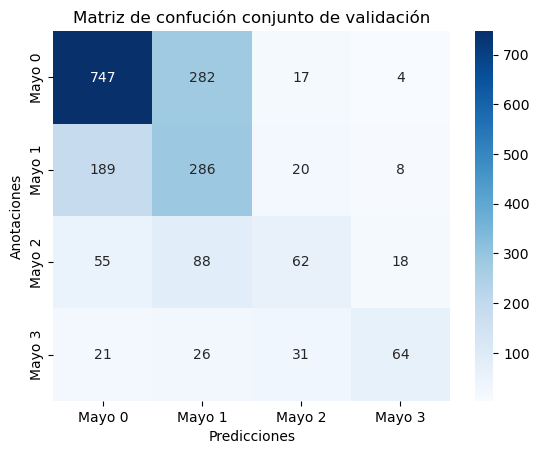

In [5]:
retval, predict_svm = svm.predict(np.array(valid['color_shape_texture'], dtype=np.float32))
print(classification_report(valid["labels"], predict_svm))


cm = confusion_matrix(valid["labels"], predict_svm)
classes = np.array([f"Mayo {i}" for i in range(4)])
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, )
ax.set_xlabel("Predicciones")
ax.set_ylabel("Anotaciones")
ax.set_title("Matriz de confución conjunto de validación")
plt.show()

### Método Final 

Para el método final cada grupo deberá utilizar los conocimientos brindados en el curso para construir un modelo de clasificación que permita determinar el Mayo Endoscopic Score a partir de imágenes de endoscopias del colon. Para esto, cada grupo puede utilizar cualquier método de aprendizaje automático supervisado, así como cualquier descriptor de imagen que considere pertinente y otras técnicas que quieran para mejorar el desempeño de su modelo.  Además, se debe realizar una experimentación exhaustiva de hiperparámetros para mejorar el desempeño del modelo final, optimizando sobre los datos de validación. 

El objetivo del método final será superar el desempeño del modelo de baseline proporcionado, en específico la métrica de f1-score macro sobre el conjunto de prueba. 

Para evaluar la eficacia de los modelos finales de cada equipo, se compararán las predicciones hechas por estos. Por lo tanto, una vez que hayan perfeccionado su modelo, cada equipo deberá predecir las etiquetas de las imágenes en el conjunto de prueba.

## Usando Pytorch resnet18

In [29]:
import torch
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms


# Definir transformaciones
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # convertir a float32 y a escala de [0,1]
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])  # Imagenet
])

#Cargar el Dataset
dataset = datasets.ImageFolder(root="ChallengeDataset/train", transform=transformations)

# separar 80/20 entrenamiento y validación
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# ejecutar los Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

from torchvision.models import resnet18
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(weights='DEFAULT')
model.fc = Linear(model.fc.in_features, 4)  # 4 Clases colitis ulcerosa
model = model.to(device)

loss_fn = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


In [13]:
from sklearn.metrics import f1_score

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)

    for step, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print(f"[{step * dataloader.batch_size}/{size}], Loss: {loss.item():.4f}")


def test_loop(dataloader, model):
    model.eval()

    labels_list = []
    predictions_list = []

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predictions = outputs.argmax(1)
            labels_list += labels.cpu().tolist()
            predictions_list += predictions.cpu().tolist()

    # Imprimir el classification_report, este permite imprimir la precision, cobertura y f1-medida de cada clase y la global
    print(classification_report(labels_list, predictions_list, target_names=[f"Clase {i}" for i in range(4)]))
    print(f"F1-score: {f1_score(labels_list, predictions_list, average='macro'):.4f}")



In [19]:
for epoch in range(8):
    print(f"\nEpoch {epoch + 1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    print("Validation\n-------------------------------")
    test_loop(val_loader, model)
    scheduler.step()



Epoch 1
-------------------------------
[0/7672], Loss: 0.0563
[640/7672], Loss: 0.0818
[1280/7672], Loss: 0.1532
[1920/7672], Loss: 0.0989
[2560/7672], Loss: 0.0728
[3200/7672], Loss: 0.0760
[3840/7672], Loss: 0.0606
[4480/7672], Loss: 0.0705
[5120/7672], Loss: 0.0736
[5760/7672], Loss: 0.3091
[6400/7672], Loss: 0.0552
[7040/7672], Loss: 0.2771
Validation
-------------------------------
              precision    recall  f1-score   support

     Clase 0       0.87      0.86      0.86      1035
     Clase 1       0.64      0.68      0.66       529
     Clase 2       0.61      0.55      0.58       219
     Clase 3       0.73      0.73      0.73       135

    accuracy                           0.77      1918
   macro avg       0.71      0.71      0.71      1918
weighted avg       0.77      0.77      0.77      1918

F1-score: 0.7082

Epoch 2
-------------------------------
[0/7672], Loss: 0.0706
[640/7672], Loss: 0.1000
[1280/7672], Loss: 0.0876
[1920/7672], Loss: 0.1042
[2560/7672], Lo

## Usando Pytorch AlexNet

In [20]:
from torchvision.models import alexnet
from torch.nn import Linear

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = alexnet(weights='DEFAULT')
model.classifier[6] = Linear(model.classifier[6].in_features, 4)
model = model.to(device)

loss_fn = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

from sklearn.metrics import f1_score

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)

    for step, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print(f"[{step * dataloader.batch_size}/{size}], Loss: {loss.item():.4f}")


def test_loop(dataloader, model):
    model.eval()

    labels_list = []
    predictions_list = []

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predictions = outputs.argmax(1)
            labels_list += labels.cpu().tolist()
            predictions_list += predictions.cpu().tolist()

    # Imprimir el classification_report, este permite imprimir la precision, cobertura y f1-medida de cada clase y la global
    print(classification_report(labels_list, predictions_list, target_names=[f"Clase {i}" for i in range(4)]))
    print(f"F1-score: {f1_score(labels_list, predictions_list, average='macro'):.4f}")

for epoch in range(3):
    print(f"\nEpoch {epoch + 1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    print("Validation\n-------------------------------")
    test_loop(val_loader, model)
    scheduler.step()


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\john2/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


100%|███████████████████████████████████████████████████████████████████████████████| 233M/233M [00:14<00:00, 16.3MB/s]



Epoch 1
-------------------------------
[0/7672], Loss: 1.5317
[640/7672], Loss: 1.0037
[1280/7672], Loss: 0.6742
[1920/7672], Loss: 0.7083
[2560/7672], Loss: 1.0114
[3200/7672], Loss: 0.7547
[3840/7672], Loss: 0.5654
[4480/7672], Loss: 0.5653
[5120/7672], Loss: 0.7715
[5760/7672], Loss: 0.7683
[6400/7672], Loss: 0.7481
[7040/7672], Loss: 0.8975
Validation
-------------------------------
              precision    recall  f1-score   support

     Clase 0       0.83      0.75      0.79      1035
     Clase 1       0.52      0.61      0.56       529
     Clase 2       0.44      0.32      0.37       219
     Clase 3       0.54      0.78      0.64       135

    accuracy                           0.67      1918
   macro avg       0.58      0.62      0.59      1918
weighted avg       0.68      0.67      0.67      1918

F1-score: 0.5902

Epoch 2
-------------------------------
[0/7672], Loss: 0.6894
[640/7672], Loss: 0.5153
[1280/7672], Loss: 0.7339
[1920/7672], Loss: 0.8545
[2560/7672], Lo

## Usando Pytorch GoogLeNet

In [22]:
from torchvision.models import googlenet
from torch.nn import Linear

# Load GoogLeNet with pretrained weights
model = googlenet(weights='DEFAULT')  

# Replace the final classification layer
model.fc = Linear(model.fc.in_features, 4)  # 4 classes
model = model.to(device)

loss_fn = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

from sklearn.metrics import f1_score

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)

    for step, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print(f"[{step * dataloader.batch_size}/{size}], Loss: {loss.item():.4f}")


def test_loop(dataloader, model):
    model.eval()

    labels_list = []
    predictions_list = []

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predictions = outputs.argmax(1)
            labels_list += labels.cpu().tolist()
            predictions_list += predictions.cpu().tolist()

    # Imprimir el classification_report, este permite imprimir la precision, cobertura y f1-medida de cada clase y la global
    print(classification_report(labels_list, predictions_list, target_names=[f"Clase {i}" for i in range(4)]))
    print(f"F1-score: {f1_score(labels_list, predictions_list, average='macro'):.4f}")

for epoch in range(3):
    print(f"\nEpoch {epoch + 1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    print("Validation\n-------------------------------")
    test_loop(val_loader, model)
    scheduler.step()



Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\john2/.cache\torch\hub\checkpoints\googlenet-1378be20.pth


100%|█████████████████████████████████████████████████████████████████████████████| 49.7M/49.7M [00:01<00:00, 28.9MB/s]



Epoch 1
-------------------------------
[0/7672], Loss: 1.5953
[640/7672], Loss: 1.0021
[1280/7672], Loss: 0.8192
[1920/7672], Loss: 0.8752
[2560/7672], Loss: 0.7934
[3200/7672], Loss: 0.5402
[3840/7672], Loss: 0.4303
[4480/7672], Loss: 0.8680
[5120/7672], Loss: 0.4771
[5760/7672], Loss: 0.4743
[6400/7672], Loss: 0.4599
[7040/7672], Loss: 0.6789
Validation
-------------------------------
              precision    recall  f1-score   support

     Clase 0       0.78      0.94      0.85      1035
     Clase 1       0.64      0.47      0.54       529
     Clase 2       0.68      0.32      0.44       219
     Clase 3       0.61      0.79      0.69       135

    accuracy                           0.73      1918
   macro avg       0.68      0.63      0.63      1918
weighted avg       0.72      0.73      0.71      1918

F1-score: 0.6313

Epoch 2
-------------------------------
[0/7672], Loss: 0.3939
[640/7672], Loss: 0.5013
[1280/7672], Loss: 0.4739
[1920/7672], Loss: 0.8480
[2560/7672], Lo

In [23]:
for epoch in range(3):
    print(f"\nEpoch {epoch + 1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    print("Validation\n-------------------------------")
    test_loop(val_loader, model)
    scheduler.step()

#Se volvio a ejecutar el codigo para observar si la f1-medida mejorada, sin embargo, a causa de que no supero al de resnort18
#se decidio en interrumpir la ejecución y seguir con el seguiente experimento


Epoch 1
-------------------------------
[0/7672], Loss: 0.3285
[640/7672], Loss: 0.2065
[1280/7672], Loss: 0.2662
[1920/7672], Loss: 0.3205
[2560/7672], Loss: 0.2535
[3200/7672], Loss: 0.2460
[3840/7672], Loss: 0.2101
[4480/7672], Loss: 0.2335
[5120/7672], Loss: 0.2642
[5760/7672], Loss: 0.3271
[6400/7672], Loss: 0.2248
[7040/7672], Loss: 0.1958
Validation
-------------------------------
              precision    recall  f1-score   support

     Clase 0       0.85      0.86      0.85      1035
     Clase 1       0.62      0.62      0.62       529
     Clase 2       0.59      0.55      0.57       219
     Clase 3       0.70      0.76      0.73       135

    accuracy                           0.75      1918
   macro avg       0.69      0.70      0.69      1918
weighted avg       0.75      0.75      0.75      1918

F1-score: 0.6942

Epoch 2
-------------------------------
[0/7672], Loss: 0.1698
[640/7672], Loss: 0.3323
[1280/7672], Loss: 0.1681
[1920/7672], Loss: 0.1661
[2560/7672], Lo

KeyboardInterrupt: 

## Al usar Resnet18 con distintos torch.optim

Usar SGD como optimizer y CosineAnneaLingLR como scheduler

In [31]:
from torchvision.models import resnet18
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR  
import torch

# Modelo resnet18
model = resnet18(weights='DEFAULT')
model.fc = Linear(model.fc.in_features, 4)
model = model.to(device)

# Función de perdida
loss_fn = CrossEntropyLoss()

#Usando SGD
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

#Usando Cosine 
scheduler = CosineAnnealingLR(optimizer, T_max=10)  # 

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)

    for step, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print(f"[{step * dataloader.batch_size}/{size}], Loss: {loss.item():.4f}")


def test_loop(dataloader, model):
    model.eval()

    labels_list = []
    predictions_list = []

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predictions = outputs.argmax(1)
            labels_list += labels.cpu().tolist()
            predictions_list += predictions.cpu().tolist()

    # Imprimir el classification_report, este permite imprimir la precision, cobertura y f1-medida de cada clase y la global
    print(classification_report(labels_list, predictions_list, target_names=[f"Clase {i}" for i in range(4)]))
    print(f"F1-score: {f1_score(labels_list, predictions_list, average='macro'):.4f}")

for epoch in range(4):
    print(f"\nEpoch {epoch + 1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    print("Validation\n-------------------------------")
    test_loop(val_loader, model)
    scheduler.step()




Epoch 1
-------------------------------
[0/7672], Loss: 1.3695
[640/7672], Loss: 0.8588
[1280/7672], Loss: 0.7470
[1920/7672], Loss: 0.9976
[2560/7672], Loss: 0.6933
[3200/7672], Loss: 0.7275
[3840/7672], Loss: 0.7868
[4480/7672], Loss: 0.7861
[5120/7672], Loss: 0.7269
[5760/7672], Loss: 0.4878
[6400/7672], Loss: 0.5887
[7040/7672], Loss: 0.7917
Validation
-------------------------------
              precision    recall  f1-score   support

     Clase 0       0.77      0.86      0.81      1035
     Clase 1       0.59      0.32      0.42       529
     Clase 2       0.37      0.50      0.42       219
     Clase 3       0.54      0.70      0.61       135

    accuracy                           0.66      1918
   macro avg       0.57      0.60      0.57      1918
weighted avg       0.66      0.66      0.65      1918

F1-score: 0.5658

Epoch 2
-------------------------------
[0/7672], Loss: 0.6183
[640/7672], Loss: 0.5367
[1280/7672], Loss: 0.4973
[1920/7672], Loss: 0.6645
[2560/7672], Lo

Usar SGD como optimizer y Linear como scheduler

In [33]:
from torchvision.models import resnet18
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import SGD
import torch

# Modelo resnet18
model = resnet18(weights='DEFAULT')
model.fc = Linear(model.fc.in_features, 4)
model = model.to(device)

# Función de perdida
loss_fn = CrossEntropyLoss()

#Usando SGD
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

#Usando StepLr
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)

    for step, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print(f"[{step * dataloader.batch_size}/{size}], Loss: {loss.item():.4f}")


def test_loop(dataloader, model):
    model.eval()

    labels_list = []
    predictions_list = []

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predictions = outputs.argmax(1)
            labels_list += labels.cpu().tolist()
            predictions_list += predictions.cpu().tolist()

    # Imprimir el classification_report, este permite imprimir la precision, cobertura y f1-medida de cada clase y la global
    print(classification_report(labels_list, predictions_list, target_names=[f"Clase {i}" for i in range(4)]))
    print(f"F1-score: {f1_score(labels_list, predictions_list, average='macro'):.4f}")

for epoch in range(4):
    print(f"\nEpoch {epoch + 1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    print("Validation\n-------------------------------")
    test_loop(val_loader, model)
    scheduler.step()




Epoch 1
-------------------------------
[0/7672], Loss: 1.3977
[640/7672], Loss: 0.9657
[1280/7672], Loss: 1.3133
[1920/7672], Loss: 1.3837
[2560/7672], Loss: 0.6082
[3200/7672], Loss: 0.7187
[3840/7672], Loss: 0.6669
[4480/7672], Loss: 0.7942
[5120/7672], Loss: 0.6133
[5760/7672], Loss: 0.6277
[6400/7672], Loss: 0.9715
[7040/7672], Loss: 0.6336
Validation
-------------------------------
              precision    recall  f1-score   support

     Clase 0       0.69      0.97      0.80      1035
     Clase 1       0.49      0.30      0.37       529
     Clase 2       0.33      0.15      0.21       219
     Clase 3       0.75      0.18      0.29       135

    accuracy                           0.64      1918
   macro avg       0.56      0.40      0.42      1918
weighted avg       0.60      0.64      0.58      1918

F1-score: 0.4172

Epoch 2
-------------------------------
[0/7672], Loss: 0.6285
[640/7672], Loss: 1.0938
[1280/7672], Loss: 0.3545
[1920/7672], Loss: 0.8610
[2560/7672], Lo

In [34]:
for epoch in range(2):
    print(f"\nEpoch {epoch + 1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    print("Validation\n-------------------------------")
    test_loop(val_loader, model)
    scheduler.step()
    
#Se decidio seguir entrenando el modelo, sin embargo a causa de que no supero el modelo de resnet18 inicial,
#Se siguio experimentando


Epoch 1
-------------------------------
[0/7672], Loss: 0.4392
[640/7672], Loss: 0.3531
[1280/7672], Loss: 0.3565
[1920/7672], Loss: 0.4924
[2560/7672], Loss: 0.6020
[3200/7672], Loss: 0.3307
[3840/7672], Loss: 0.3156
[4480/7672], Loss: 0.4236
[5120/7672], Loss: 0.3552
[5760/7672], Loss: 0.4542
[6400/7672], Loss: 0.4608
[7040/7672], Loss: 0.3269
Validation
-------------------------------
              precision    recall  f1-score   support

     Clase 0       0.85      0.92      0.88      1035
     Clase 1       0.68      0.60      0.64       529
     Clase 2       0.57      0.49      0.53       219
     Clase 3       0.71      0.76      0.73       135

    accuracy                           0.77      1918
   macro avg       0.70      0.69      0.70      1918
weighted avg       0.76      0.77      0.77      1918

F1-score: 0.6964

Epoch 2
-------------------------------
[0/7672], Loss: 0.4823
[640/7672], Loss: 0.4901
[1280/7672], Loss: 0.4196
[1920/7672], Loss: 0.3839
[2560/7672], Lo

Usar AdamW como optimizer y CosineAnneaLingLR como scheduler

In [36]:
from torchvision.models import resnet18
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR  
import torch

# Modelo resnet18
model = resnet18(weights='DEFAULT')
model.fc = Linear(model.fc.in_features, 4)
model = model.to(device)

# Función de perdida
loss_fn = CrossEntropyLoss()

#Usando AdamW
optimizer = AdamW(model.parameters(), lr = 1e-4)

#Usando Coseno
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)

    for step, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print(f"[{step * dataloader.batch_size}/{size}], Loss: {loss.item():.4f}")


def test_loop(dataloader, model):
    model.eval()

    labels_list = []
    predictions_list = []

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predictions = outputs.argmax(1)
            labels_list += labels.cpu().tolist()
            predictions_list += predictions.cpu().tolist()

    # Imprimir el classification_report, este permite imprimir la precision, cobertura y f1-medida de cada clase y la global
    print(classification_report(labels_list, predictions_list, target_names=[f"Clase {i}" for i in range(4)]))
    print(f"F1-score: {f1_score(labels_list, predictions_list, average='macro'):.4f}")

for epoch in range(4):
    print(f"\nEpoch {epoch + 1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    print("Validation\n-------------------------------")
    test_loop(val_loader, model)
    scheduler.step()


Epoch 1
-------------------------------
[0/7672], Loss: 1.4362
[640/7672], Loss: 1.0000
[1280/7672], Loss: 0.5898
[1920/7672], Loss: 0.6623
[2560/7672], Loss: 0.9011
[3200/7672], Loss: 0.7377
[3840/7672], Loss: 0.5211
[4480/7672], Loss: 0.8189
[5120/7672], Loss: 0.7177
[5760/7672], Loss: 0.5365
[6400/7672], Loss: 0.4325
[7040/7672], Loss: 0.5237
Validation
-------------------------------
              precision    recall  f1-score   support

     Clase 0       0.85      0.89      0.87      1035
     Clase 1       0.67      0.62      0.64       529
     Clase 2       0.57      0.41      0.47       219
     Clase 3       0.62      0.83      0.71       135

    accuracy                           0.76      1918
   macro avg       0.68      0.69      0.67      1918
weighted avg       0.75      0.76      0.75      1918

F1-score: 0.6739

Epoch 2
-------------------------------
[0/7672], Loss: 0.3854
[640/7672], Loss: 0.4994
[1280/7672], Loss: 0.5319
[1920/7672], Loss: 0.3980
[2560/7672], Lo

Usar SGD como optimizer y ReduceLROnPlateau como scheduler

In [38]:
from torchvision.models import resnet18
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau  
import torch

# Modelo resnet18
model = resnet18(weights='DEFAULT')
model.fc = Linear(model.fc.in_features, 4)
model = model.to(device)

# Función de perdida
loss_fn = CrossEntropyLoss()

#Usando SGD
optimizer = SGD(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)

    for step, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print(f"[{step * dataloader.batch_size}/{size}], Loss: {loss.item():.4f}")


def test_loop(dataloader, model):
    model.eval()

    labels_list = []
    predictions_list = []

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predictions = outputs.argmax(1)
            labels_list += labels.cpu().tolist()
            predictions_list += predictions.cpu().tolist()

    # Imprimir el classification_report, este permite imprimir la precision, cobertura y f1-medida de cada clase y la global
    print(classification_report(labels_list, predictions_list, target_names=[f"Clase {i}" for i in range(4)]))
    print(f"F1-score: {f1_score(labels_list, predictions_list, average='macro'):.4f}")

for epoch in range(4):
    print(f"\nEpoch {epoch + 1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    print("Validation\n-------------------------------")
    test_loop(val_loader, model)
    scheduler.step()
    
    
#El peor Modelo 🤡


Epoch 1
-------------------------------
[0/7672], Loss: 1.7736
[640/7672], Loss: 1.4880
[1280/7672], Loss: 1.3169
[1920/7672], Loss: 1.3818
[2560/7672], Loss: 1.2819
[3200/7672], Loss: 1.1889
[3840/7672], Loss: 1.1006
[4480/7672], Loss: 1.3056
[5120/7672], Loss: 1.2959
[5760/7672], Loss: 1.1431
[6400/7672], Loss: 1.3457
[7040/7672], Loss: 1.0699
Validation
-------------------------------
              precision    recall  f1-score   support

     Clase 0       0.55      0.96      0.70      1035
     Clase 1       0.32      0.07      0.11       529
     Clase 2       0.33      0.00      0.01       219
     Clase 3       0.00      0.00      0.00       135

    accuracy                           0.54      1918
   macro avg       0.30      0.26      0.20      1918
weighted avg       0.42      0.54      0.41      1918

F1-score: 0.2049


TypeError: ReduceLROnPlateau.step() missing 1 required positional argument: 'metrics'

## Usando ResNeXt

In [7]:
from torchvision.models import resnext50_32x4d
from torch.nn import Linear

model = resnext50_32x4d(weights='DEFAULT')
model.fc = Linear(model.fc.in_features, 4)
model = model.to(device)
loss_fn = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

from sklearn.metrics import f1_score

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)

    for step, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print(f"[{step * dataloader.batch_size}/{size}], Loss: {loss.item():.4f}")


def test_loop(dataloader, model):
    model.eval()

    labels_list = []
    predictions_list = []

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predictions = outputs.argmax(1)
            labels_list += labels.cpu().tolist()
            predictions_list += predictions.cpu().tolist()

    # Imprimir el classification_report, este permite imprimir la precision, cobertura y f1-medida de cada clase y la global
    print(classification_report(labels_list, predictions_list, target_names=[f"Clase {i}" for i in range(4)]))
    print(f"F1-score: {f1_score(labels_list, predictions_list, average='macro'):.4f}")

for epoch in range(4):
    print(f"\nEpoch {epoch + 1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    print("Validation\n-------------------------------")
    test_loop(val_loader, model)
    scheduler.step()



Epoch 1
-------------------------------
[0/7672], Loss: 1.3479
[640/7672], Loss: 0.8335
[1280/7672], Loss: 1.0155
[1920/7672], Loss: 0.4738
[2560/7672], Loss: 0.6120
[3200/7672], Loss: 0.5641
[3840/7672], Loss: 0.5027
[4480/7672], Loss: 0.8174
[5120/7672], Loss: 0.6037
[5760/7672], Loss: 0.6261
[6400/7672], Loss: 0.5634
[7040/7672], Loss: 0.5260
Validation
-------------------------------
              precision    recall  f1-score   support

     Clase 0       0.87      0.88      0.87      1035
     Clase 1       0.69      0.56      0.62       529
     Clase 2       0.53      0.68      0.60       219
     Clase 3       0.63      0.79      0.70       135

    accuracy                           0.76      1918
   macro avg       0.68      0.73      0.70      1918
weighted avg       0.77      0.76      0.76      1918

F1-score: 0.6980

Epoch 2
-------------------------------
[0/7672], Loss: 0.4934
[640/7672], Loss: 0.2667
[1280/7672], Loss: 0.1863
[1920/7672], Loss: 0.2182
[2560/7672], Lo

## Usando Resnet50

In [8]:
from torchvision.models import resnet50
from torch.nn import Linear

model = resnet50(weights='DEFAULT')
model.fc = Linear(model.fc.in_features, 4)
model = model.to(device)
loss_fn = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

from sklearn.metrics import f1_score

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)

    for step, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print(f"[{step * dataloader.batch_size}/{size}], Loss: {loss.item():.4f}")


def test_loop(dataloader, model):
    model.eval()

    labels_list = []
    predictions_list = []

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predictions = outputs.argmax(1)
            labels_list += labels.cpu().tolist()
            predictions_list += predictions.cpu().tolist()

    # Imprimir el classification_report
    print(classification_report(labels_list, predictions_list, target_names=[f"Clase {i}" for i in range(4)]))
    print(f"F1-score: {f1_score(labels_list, predictions_list, average='macro'):.4f}")

for epoch in range(4):
    print(f"\nEpoch {epoch + 1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    print("Validation\n-------------------------------")
    test_loop(val_loader, model)
    scheduler.step()


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\john2/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 45.2MB/s]



Epoch 1
-------------------------------
[0/7672], Loss: 1.3824
[640/7672], Loss: 1.0214
[1280/7672], Loss: 0.8316
[1920/7672], Loss: 0.8394
[2560/7672], Loss: 0.6626
[3200/7672], Loss: 0.7728
[3840/7672], Loss: 0.5056
[4480/7672], Loss: 0.7089
[5120/7672], Loss: 0.5466
[5760/7672], Loss: 0.7937
[6400/7672], Loss: 0.6013
[7040/7672], Loss: 0.6426
Validation
-------------------------------
              precision    recall  f1-score   support

     Clase 0       0.83      0.92      0.87      1035
     Clase 1       0.65      0.60      0.62       529
     Clase 2       0.63      0.42      0.50       219
     Clase 3       0.73      0.70      0.71       135

    accuracy                           0.76      1918
   macro avg       0.71      0.66      0.68      1918
weighted avg       0.75      0.76      0.75      1918

F1-score: 0.6785

Epoch 2
-------------------------------
[0/7672], Loss: 0.3864
[640/7672], Loss: 0.3119
[1280/7672], Loss: 0.5981
[1920/7672], Loss: 0.4987
[2560/7672], Lo

## El modelo Resnet50 supero la F1-medida del Resnet18 Inicial

## Ampliando la Base de datos

In [21]:
import os
import cv2
import random
import numpy as np
from glob import glob
from tqdm import tqdm
from shutil import copyfile

original_dir = "ChallengeDataset/train"
augmented_dir = "ChallengeDataset/train_augmented"
transformations = [
    "flip", "brightness and contrast", "rotate", "scale", "translate", "blur", "randomcrop", "pad" 
]
augment_per_image = 2  # Se genera 2 imagenes nuevas en el database, más la original, por lo que el nuevo database es 3 veces mayor

# ===FUNCIÓN DE AUGMENTATION DEL DATABASE ===

def data_augmentation(Im, transformations, target_size=(256, 256), alpha_factor=(0.9, 1.1), beta_factor=(-30, 30)):
    augmented = Im.copy()

    # Flip
    if "flip" in transformations:
        augmented = cv2.flip(augmented, 1)
    
    if "brightness and contrast" in transformations:
        alpha = random.uniform(*alpha_factor)
        beta = random.uniform(*beta_factor)
        augmented = cv2.convertScaleAbs(augmented, alpha=alpha, beta=beta)
    
    # Rotate
    if "rotate" in transformations:
        angle = random.uniform(-10, 10)
        h, w = augmented.shape[:2]
        M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
        augmented = cv2.warpAffine(augmented, M, (w, h))

    # Scale
    if "scale" in transformations:
        scale = random.uniform(0.9, 1.1)
        augmented = cv2.resize(augmented, None, fx=scale, fy=scale)
        augmented = cv2.resize(augmented, (Im.shape[1], Im.shape[0]))

    # Translate
    if "translate" in transformations:
        tx = random.randint(-10, 10)
        ty = random.randint(-10, 10)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        augmented = cv2.warpAffine(augmented, M, (Im.shape[1], Im.shape[0]))

    # Blur
    if "blur" in transformations:
        ksize = random.choice([3, 5])
        augmented = cv2.GaussianBlur(augmented, (ksize, ksize), 0)

    if "randomcrop" in transformations:
        h, w = augmented.shape[:2]
        crop_size = random.randint(int(0.8*h), h)
        x_start = random.randint(0, w - crop_size)
        y_start = random.randint(0, h - crop_size)
        cropped = augmented[y_start:y_start+crop_size, x_start:x_start+crop_size]
        augmented = cv2.resize(cropped, (target_size[1], target_size[0]))

    # Padding
    if "pad" in transformations:
        pad = 10
        augmented = cv2.copyMakeBorder(augmented, pad, pad, pad, pad, cv2.BORDER_REFLECT)
        augmented = cv2.resize(augmented, (target_size[1], target_size[0]))
        

    return augmented


# === Crear el nuevo database ===
os.makedirs(augmented_dir, exist_ok=True)

for class_folder in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_folder)
    aug_class_path = os.path.join(augmented_dir, class_folder)
    os.makedirs(aug_class_path, exist_ok=True)

    image_paths = glob(os.path.join(class_path, "*.bmp"))

    for img_path in tqdm(image_paths, desc=f"Augmenting {class_folder}"):
        filename = os.path.basename(img_path)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Copiar el original
        copyfile(img_path, os.path.join(aug_class_path, filename))

        # Generate N aumentos
        for i in range(augment_per_image):
            aug_img = data_augmentation(img, transformations)
            aug_filename = f"{os.path.splitext(filename)[0]}_aug{i}.bmp"
            cv2.imwrite(os.path.join(aug_class_path, aug_filename), aug_img)

Augmenting Mayo 3: 100%|█████████████████████████████████████████████████████████████| 745/745 [00:10<00:00, 73.17it/s]


In [24]:
print(len("ChallengeDataset/train_augmented/Mayo 2"))


39


In [39]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
# Cargar el nuevo database

augmented_dataset = datasets.ImageFolder("ChallengeDataset/train_augmented", transform=transform)

train_size = int(0.85 * len(augmented_dataset))  # Dividar la data en 85 para entrenamiento y 15 para validación
val_size2 = len(augmented_dataset) - train_size
train_dataset, val_dataset2 = random_split(augmented_dataset, [train_size, val_size2], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader2 = DataLoader(val_dataset2, batch_size=32)

Se usa Resnet18 entrenada con la database aumentada y se valida usando la validación del database original

In [26]:
from torchvision.models import resnet18
from torch.nn import Linear

model = resnet18(weights='DEFAULT')
model.fc = Linear(model.fc.in_features, 4)
model = model.to(device)
loss_fn = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

from sklearn.metrics import f1_score

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)

    for step, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print(f"[{step * dataloader.batch_size}/{size}], Loss: {loss.item():.4f}")


def test_loop(dataloader, model):
    model.eval()

    labels_list = []
    predictions_list = []

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predictions = outputs.argmax(1)
            labels_list += labels.cpu().tolist()
            predictions_list += predictions.cpu().tolist()

    # Imprimir el classification_report, este permite imprimir la precision, cobertura y f1-medida de cada clase y la global
    print(classification_report(labels_list, predictions_list, target_names=[f"Clase {i}" for i in range(4)]))
    print(f"F1-score: {f1_score(labels_list, predictions_list, average='macro'):.4f}")

for epoch in range(4):
    print(f"\nEpoch {epoch + 1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    print("Validation\n-------------------------------")
    test_loop(val_loader, model)
    scheduler.step()



Epoch 1
-------------------------------
[0/25893], Loss: 1.3803
[640/25893], Loss: 1.0802
[1280/25893], Loss: 0.8725
[1920/25893], Loss: 0.8464
[2560/25893], Loss: 0.6777
[3200/25893], Loss: 0.4432
[3840/25893], Loss: 0.5461
[4480/25893], Loss: 0.8558
[5120/25893], Loss: 0.6072
[5760/25893], Loss: 0.5970
[6400/25893], Loss: 0.6540
[7040/25893], Loss: 0.8907
[7680/25893], Loss: 0.6802
[8320/25893], Loss: 0.5354
[8960/25893], Loss: 0.4075
[9600/25893], Loss: 0.5953
[10240/25893], Loss: 0.5706
[10880/25893], Loss: 0.5999
[11520/25893], Loss: 0.4171
[12160/25893], Loss: 0.4447
[12800/25893], Loss: 0.3621
[13440/25893], Loss: 0.6139
[14080/25893], Loss: 0.5012
[14720/25893], Loss: 0.6534
[15360/25893], Loss: 0.7568
[16000/25893], Loss: 0.6908
[16640/25893], Loss: 0.5467
[17280/25893], Loss: 0.4891
[17920/25893], Loss: 0.7697
[18560/25893], Loss: 0.5608
[19200/25893], Loss: 0.5484
[19840/25893], Loss: 0.4630
[20480/25893], Loss: 0.5965
[21120/25893], Loss: 0.4351
[21760/25893], Loss: 0.5568

KeyboardInterrupt: 

Se usa Resnet18 entrenada con el database aumentado y se valida usando la validación del database aumentado

In [28]:
from torchvision.models import resnet18
from torch.nn import Linear

model = resnet18(weights='DEFAULT')
model.fc = Linear(model.fc.in_features, 4)
model = model.to(device)
loss_fn = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

from sklearn.metrics import f1_score

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)

    for step, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print(f"[{step * dataloader.batch_size}/{size}], Loss: {loss.item():.4f}")


def test_loop(dataloader, model):
    model.eval()

    labels_list = []
    predictions_list = []

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predictions = outputs.argmax(1)
            labels_list += labels.cpu().tolist()
            predictions_list += predictions.cpu().tolist()

    # Imprimir el classification_report, este permite imprimir la precision, cobertura y f1-medida de cada clase y la global
    print(classification_report(labels_list, predictions_list, target_names=[f"Clase {i}" for i in range(4)]))
    print(f"F1-score: {f1_score(labels_list, predictions_list, average='macro'):.4f}")

for epoch in range(4):
    print(f"\nEpoch {epoch + 1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    print("Validation\n-------------------------------")
    test_loop(val_loader2, model)
    scheduler.step()



Epoch 1
-------------------------------
[0/24454], Loss: 1.3534
[640/24454], Loss: 0.7637
[1280/24454], Loss: 0.5595
[1920/24454], Loss: 0.6199
[2560/24454], Loss: 0.7682
[3200/24454], Loss: 0.5223
[3840/24454], Loss: 0.5724
[4480/24454], Loss: 0.5939
[5120/24454], Loss: 0.4876
[5760/24454], Loss: 0.5465
[6400/24454], Loss: 0.5506
[7040/24454], Loss: 0.6380
[7680/24454], Loss: 0.7203
[8320/24454], Loss: 0.5977
[8960/24454], Loss: 0.4762
[9600/24454], Loss: 0.6613
[10240/24454], Loss: 0.7631
[10880/24454], Loss: 0.5848
[11520/24454], Loss: 0.6405
[12160/24454], Loss: 0.5193
[12800/24454], Loss: 0.4186
[13440/24454], Loss: 0.6305
[14080/24454], Loss: 0.4907
[14720/24454], Loss: 0.6438
[15360/24454], Loss: 0.6532
[16000/24454], Loss: 0.6719
[16640/24454], Loss: 0.6044
[17280/24454], Loss: 0.4120
[17920/24454], Loss: 0.4763
[18560/24454], Loss: 0.4821
[19200/24454], Loss: 0.4698
[19840/24454], Loss: 0.3774
[20480/24454], Loss: 0.4277
[21120/24454], Loss: 0.3628
[21760/24454], Loss: 0.5063

Se usa Resnet34 entrenada con el database aumentado y se valida usando la validación del database aumentado

In [40]:
from torchvision.models import resnet34
from torch.nn import Linear

model2 = resnet34(weights='DEFAULT')
model2.fc = Linear(model2.fc.in_features, 4)
model2 = model2.to(device)
loss_fn = CrossEntropyLoss()
optimizer = AdamW(model2.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

from sklearn.metrics import f1_score

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)

    for step, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        if step % 20 == 0:
            print(f"[{step * dataloader.batch_size}/{size}], Loss: {loss.item():.4f}")


def test_loop(dataloader, model):
    model.eval()

    labels_list = []
    predictions_list = []

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predictions = outputs.argmax(1)
            labels_list += labels.cpu().tolist()
            predictions_list += predictions.cpu().tolist()

    # Imprimir el classification_report, este permite imprimir la precision, cobertura y f1-medida de cada clase y la global
    print(classification_report(labels_list, predictions_list, target_names=[f"Clase {i}" for i in range(4)]))
    print(f"F1-score: {f1_score(labels_list, predictions_list, average='macro'):.4f}")

for epoch in range(4):
    print(f"\nEpoch {epoch + 1}\n-------------------------------")
    train_loop(train_loader, model2, loss_fn, optimizer)
    print("Validation\n-------------------------------")
    test_loop(val_loader2, model2)
    scheduler.step()


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\john2/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:02<00:00, 39.9MB/s]



Epoch 1
-------------------------------
[0/24454], Loss: 1.7309
[640/24454], Loss: 1.1552
[1280/24454], Loss: 0.6057
[1920/24454], Loss: 0.6357
[2560/24454], Loss: 0.7121
[3200/24454], Loss: 0.7243
[3840/24454], Loss: 0.8775
[4480/24454], Loss: 0.7479
[5120/24454], Loss: 0.5226
[5760/24454], Loss: 0.7503
[6400/24454], Loss: 0.4942
[7040/24454], Loss: 0.6529
[7680/24454], Loss: 0.6809
[8320/24454], Loss: 0.7822
[8960/24454], Loss: 0.4974
[9600/24454], Loss: 0.4834
[10240/24454], Loss: 0.5658
[10880/24454], Loss: 0.5931
[11520/24454], Loss: 0.8067
[12160/24454], Loss: 0.4026
[12800/24454], Loss: 0.4353
[13440/24454], Loss: 0.3792
[14080/24454], Loss: 0.5229
[14720/24454], Loss: 0.5460
[15360/24454], Loss: 0.5458
[16000/24454], Loss: 0.3614
[16640/24454], Loss: 0.7883
[17280/24454], Loss: 0.6502
[17920/24454], Loss: 0.5757
[18560/24454], Loss: 0.5612
[19200/24454], Loss: 0.5458
[19840/24454], Loss: 0.5888
[20480/24454], Loss: 0.5437
[21120/24454], Loss: 0.3879
[21760/24454], Loss: 0.6245

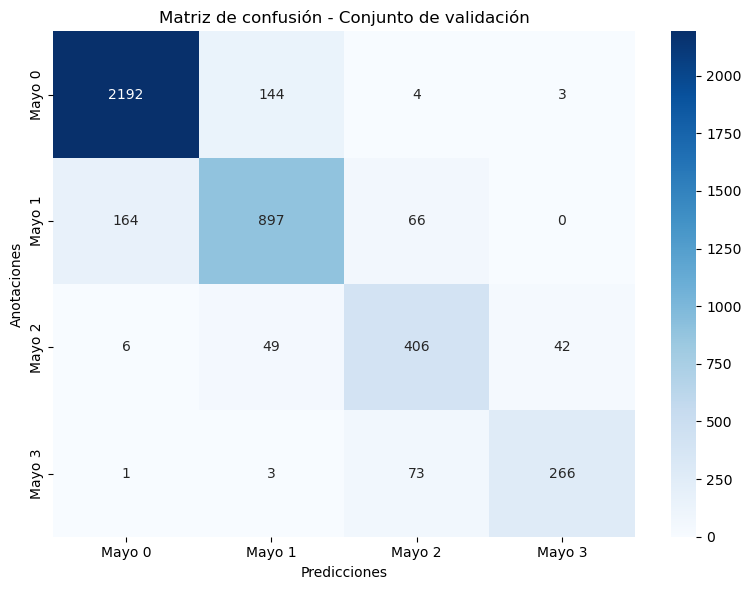

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Colleccionar el val_loader2
model2.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, labels in val_loader2:
        data, labels = data.to(device), labels.to(device)
        outputs = model2(data)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Crear la matrix de confusion
cm = confusion_matrix(all_labels, all_preds)
classes = np.array([f"Mayo {i}" for i in range(4)])

# Plot la matrix de confusión
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                 xticklabels=classes, yticklabels=classes)
ax.set_xlabel("Predicciones")
ax.set_ylabel("Anotaciones")
ax.set_title("Matriz de confusión - Conjunto de validación")
plt.tight_layout()
plt.show()



### Entregables

En los archivos adjuntos al Challenge se incluye `TestPredictionsEmpty.csv`. Este archivo consta de dos columnas: la primera con el nombre de cada imagen del conjunto de prueba y la segunda con un valor predeterminado de _NaN_. Cada grupo deberá completar este archivo, reemplazando el valor _NaN_ de cada imagen con la predicción del Mayo Endoscopic Score ("Mayo 0", "Mayo 1", "Mayo 2" o "Mayo 3") generada por su modelo, y guardarlo como `TestPredictions.csv`. Este último archivo será utilizado para evaluar el desempeño de cada modelo mediante su comparación con las anotaciones reales. 

In [45]:
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm

classes = np.array([f"Mayo {i}" for i in range(4)])

test_predictions_empty = pd.read_csv("TestPredictionsEmpty.csv")
print(test_predictions_empty)

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Predecir los labels en el test
model2.eval()
predictions = []

# recorres las imagenes de test
for img_name in tqdm(test_predictions_empty["Images"]):
    img_path = os.path.join("ChallengeDataset/test", img_name)
    image = Image.open(img_path).convert("RGB")
    input_tensor = test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model2(input_tensor)
        pred_class = output.argmax(1).item()
        predictions.append(classes[pred_class])

# Guardar en un CSV
test_predictions_empty["Labels"] = predictions
test_predictions_empty.to_csv("TestPredictions.csv", index=False)

        Images  Labels
0        0.bmp     NaN
1        1.bmp     NaN
2        2.bmp     NaN
3        3.bmp     NaN
4        4.bmp     NaN
...        ...     ...
1681  1681.bmp     NaN
1682  1682.bmp     NaN
1683  1683.bmp     NaN
1684  1684.bmp     NaN
1685  1685.bmp     NaN

[1686 rows x 2 columns]


100%|██████████████████████████████████████████████████████████████████████████████| 1686/1686 [02:41<00:00, 10.41it/s]


De manera que el entregable de este Challenge es un archivo `.zip` que contiene: 
1. Archivo `TestPredictions.csv` que contiene el MES predicho por el método final.
2. Un cuaderno de Jupyter `MetodoFinalGrupoX.ipynb` done _X_ corresponde al número del grupo y contiene el código con la implementación del método final de dicho grupo. 

### Evaluación
La evaluación del Challenge se realizará con el archivo `TestPredictions.csv` que deberá contener el MES predicho por el método final para el conjunto de prueba. Para esto, se utilizarán las métricas de evaluación cuantitativa de clasificación: precisión, recall y F1-score y se compararán con las métricas obtenidas por el modelo de baseline. Todos los grupos que superen la métrica $\textbf{F1-score de prueba}$ $(0.49)$ del baseline tendrán un bono en la nota final del curso, donde el grupo que obtenga el mejor desempeño en la métrica de $\textbf{prueba}$ tendrá +0.5 puntos y a partir de este se irá disminuyendo el bono hasta 0.1 punto para el grupo con el peor despeño por encima del baseline. 

A continuación se presenta el código que se utilizará para evaluar el desempeño del método final, en particular los resultados que se observan inicialmente son los del Baseline. 

Cabe resaltar que el archivo `TestAnnotations.csv` no estará disponible durante la realización del Challenge, por lo que es de esperar que al ejecutar la siguiente celda se genere un error. 

In [44]:
test_annotations = pd.read_csv("TestAnnotations.csv")
test_predictions = pd.read_csv("TestPredictions.csv")
print(classification_report(test_annotations["Labels"], test_predictions["Labels"]))

cm = confusion_matrix(test_annotations["Labels"], test_predictions["Labels"])
classes = [f"Mayo {i}" for i in range(4)]
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, )
ax.set_xlabel("Predicciones")
ax.set_ylabel("Anotaciones")
ax.set_title("Matriz de confución conjunto de prueba")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'TestAnnotations.csv'